In [1]:
import numpy as np
import pyodbc
import pandas as pd
from apriori_python.apriori_algo import *
from apriori_python.utils import *
import ast

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3888\1725033720.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# # may need to change the input format depends on the ETL
# df = pd.read_csv('output_csv/table1.csv')
# # res = df['Item'].tolist()
# itemSetList = []
# # |D| = 31465
# for value in df['Item']:
#     val = ast.literal_eval(value)
#     itemSetList.append(val)

In [3]:
# test on data of the paper
dfs = pd.read_excel('data/table1.xlsx')

res = dfs['Item'].tolist()
# print(res)
itemSetList = []
for value in dfs['Item']:
    # Remove brackets from the string
    value = value.strip('[]')

    # Split the string by commas (or any other delimiter)
    list_from_string = value.split(',')

    # Convert each element to integers (if needed)
    list_from_string = [item for item in list_from_string]
    itemSetList.append(list_from_string)
print(itemSetList)

[['A', 'B', 'C', 'D'], ['A', 'B', 'E'], ['A', 'C'], ['B', 'D', 'E'], ['A', 'B', 'C', 'D'], ['C'], ['A', 'C']]


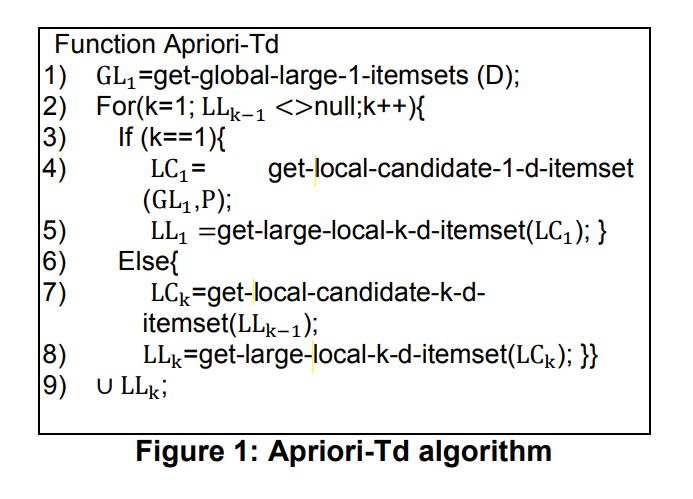

## Step 1: get global large 1 itemsets

In [29]:
# itemSetList = [['eggs', 'bacon', 'soup'],
#                 ['eggs', 'bacon', 'apple'],
#                 ['soup', 'bacon', 'banana']]
# minSup = 0.01
global_sup = 0.4  # sigma_g
local_sup = 0.2   # sigma_l 
temporal_sup = 3  # sigma_t 3 days
conf_thres = 0.5  # sigma_c 
sf = 1.3
gf = 0.7

# freqItemSet, rules = apriori(itemSetList_0, minSup=0.01, minConf=0.5)

# get all the unique items in the itemSetList
C1ItemSet = getItemSetFromList(itemSetList)
# print(C1ItemSet)

globalItemSetWithSup = defaultdict(int)

GL1 = getAboveMinSup(C1ItemSet, itemSetList, global_sup, globalItemSetWithSup)
print(GL1)


{frozenset({'A'}): 0.71, frozenset({'C'}): 0.71, frozenset({'B'}): 0.57, frozenset({'D'}): 0.43}


## Step 2: Generate LC1 from GL1
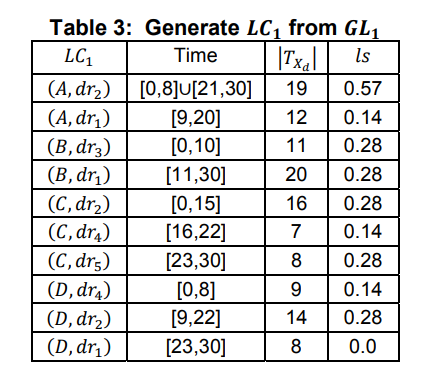

In [30]:
# read the second table
df2 = pd.read_excel('data/table2.xlsx')

res1 = dfs.values.tolist()
res2 = df2.values.tolist()
# print(res2)

# convert the GL1 elements from frozen set to list
sets = [list(s) for s in GL1]
sets.sort()
data = []

LC1 = ('X', 'Y')
Time = [0,0]
Tx = 0
ls = 0
count = 0
for x in sets:
    for y in res2:
        if set(x).issubset(set(y)):
            LC1 = (y[0],y[1])
            Time = (y[2],y[3])
            Tx = y[3] - y[2] + 1

            for z in res1:
                if set(x).issubset(set(z[1])) and z[2] >= Time[0] and z[2] <= Time[1]:
                    # print(count, z[2], Time[0], Time[1])
                    count += 1
            
            # Create a dictionary of values
            values = {'LC1': LC1, 'Time': Time, 'Tx': Tx, 'ls': float(count / len(res1))}
                    
            # Append the values to the DataFrame
            data.append(values)
            count = 0
    
            
df3 = pd.DataFrame(data)


def tolist(series):
    return series.tolist()


df4 = df3.groupby('LC1').agg({'Time': tolist, 'Tx': 'sum', 'ls': 'sum'}).reset_index()

print(df4)


        LC1                Time  Tx        ls
0  (A, dr1)           [(9, 20)]  12  0.142857
1  (A, dr2)  [(0, 8), (21, 30)]  19  0.571429
2  (B, dr1)          [(11, 30)]  20  0.285714
3  (B, dr3)           [(0, 10)]  11  0.285714
4  (C, dr2)           [(0, 15)]  16  0.285714
5  (C, dr4)          [(16, 22)]   7  0.142857
6  (C, dr5)          [(23, 30)]   8  0.285714
7  (D, dr1)          [(23, 30)]   8  0.000000
8  (D, dr2)           [(9, 22)]  14  0.285714
9  (D, dr4)            [(0, 8)]   9  0.142857


## Step 3 : Generate LL1 from LC1

In [36]:
data = []
for index, row in df4.iterrows():
    if row['ls'] >= local_sup:
        count = 0
        count2 = 0
        support = GL1[frozenset(row['LC1'][0])]
        for i in res1:
            timeStamp = i[2]
            for j in row['Time']:
                if timeStamp >= j[0] and timeStamp <= j[1]:
                    count += 1
                    if set(row['LC1'][0]).issubset(set(i[1])):
                        count2 += 1
        ef = round(count2 / count / support, 2)

        if ef < sf and ef > gf:
            effect = 0
        elif ef >= sf:
            effect = 1
        else:
            effect = -1

        values = {'LL1': row['LC1'], 'Time': row['Time'], 'rs': float(count2 / count), 's': support, 'EF': ef, 'Effect': effect}        
        data.append(values)

df5 = pd.DataFrame(data)
print(df5)


        LL1                Time        rs     s    EF  Effect
0  (A, dr2)  [(0, 8), (21, 30)]  0.800000  0.71  1.13       0
1  (B, dr1)          [(11, 30)]  0.400000  0.57  0.70      -1
2  (B, dr3)           [(0, 10)]  1.000000  0.57  1.75       1
3  (C, dr2)           [(0, 15)]  0.666667  0.71  0.94       0
4  (C, dr5)          [(23, 30)]  1.000000  0.71  1.41       1
5  (D, dr2)           [(9, 22)]  0.666667  0.43  1.55       1
